# **TYBA** -  Caso de prueba - Marketing de bancos 




#### Juan Manuel Rodríguez Barragán - juanrodriguezbar@gmail.com

-------

El dataset que voy a tratar (Bank.csv) contiene información de *campañas de marketing bancarias* y el approach que quiero darle a este notebook es un approach de predicción de *conversión* de clientes a un producto determinado dado ciertos inputs.   

Metodología: 
1. Importar data del dataset y realizar un análisis diagnóstico, un AS-IS de la información en bruto  

2. Limpiar la data: Remover columnas que no se van a tratar, convertir los datos a los tipos correctos, convertir variables categoricas en variables dummy, etc.   

3. Con la ayuda de las librerías de machine learning y bajo el marco de una campaña de marketing bancaria, encontrar los factores que hacen que una campaña sea exitosa o no. Y cómo sería posible optimizar la conversión de la misma.  




------------------------------------------



#### Importar librerías a usar: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import os
print(os.listdir("../tyba"))


['.ipynb_checkpoints', 'bank.csv', 'columns_distribution.PNG', 'tyba_notebook.ipynb']


------------------------------------------



#### Importar y hacer un diagnóstico general de la información: 

In [2]:
df = pd.read_csv('../tyba/bank.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
print("El dataset contiene {rows} filas".format(rows = len(df)))

El dataset contiene 11162 filas


In [4]:
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

Como podemos observar, no existen valores nulos. Si los hubiese, sería necesario llenar dichos valores con la mediana, media o moda. (Personalmente preferiría la mediana) 

## Descripción variable a variable del dataset: 

1. age: indica la edad del cliente (numeric)  

2. job: indica el tipo de trabajo del cliente (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  

3. marital: Indica el estado civil del cliente (categorical: 'divorced','married','single','unknown')

4. education: Indica el nivel de escolaridad del cliente (categorical: primary, secondary, tertiary and unknown)  

5. default: Tiene crédito por defecto? (categorical: 'no','yes','unknown')

6. housing: Tiene un préstamo de vivienda? (categorical: 'no','yes','unknown')  

7. loan: Tiene un préstamo personal? (categorical: 'no','yes','unknown')  

8. balance: Balance del cliente  

9. contact: Modo de comunicación con el cliente (categorical: 'cellular','telephone')  

10. month: Último mes de contacto (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  

11. day: Último día de la semana en el que fue contactado (categorical: 'mon','tue','wed','thu','fri')  

12. duration: duración en segundos de la llamada (numeric).  

13. campaign: Número de contactos realizados para esta campaña y en específico para dicho cliente (numeric)  

14. pdays: Número de días que han transcurrido desde que el cliente fue contactado por última vez por alguna campaña previa de la compañía  (numeric; 999 significa que no hubo contacto previo)  

15. previous: Número de contactos realizados antes de ésta campaña para este cliente en específico (numeric)  

16. poutcome: Resultado de la anterior campaña de marketing (categorical: 'failure','nonexistent','success')

Variable objetivo: 
- Deposit:  El cliente se ha suscrito al producto de la campaña? (binary: 'yes','no')





-------------------------------


###### El dataset consta de columnas categóricas y númericas. En cuanto a las columnas categóricas tenemos los siguientes charts:



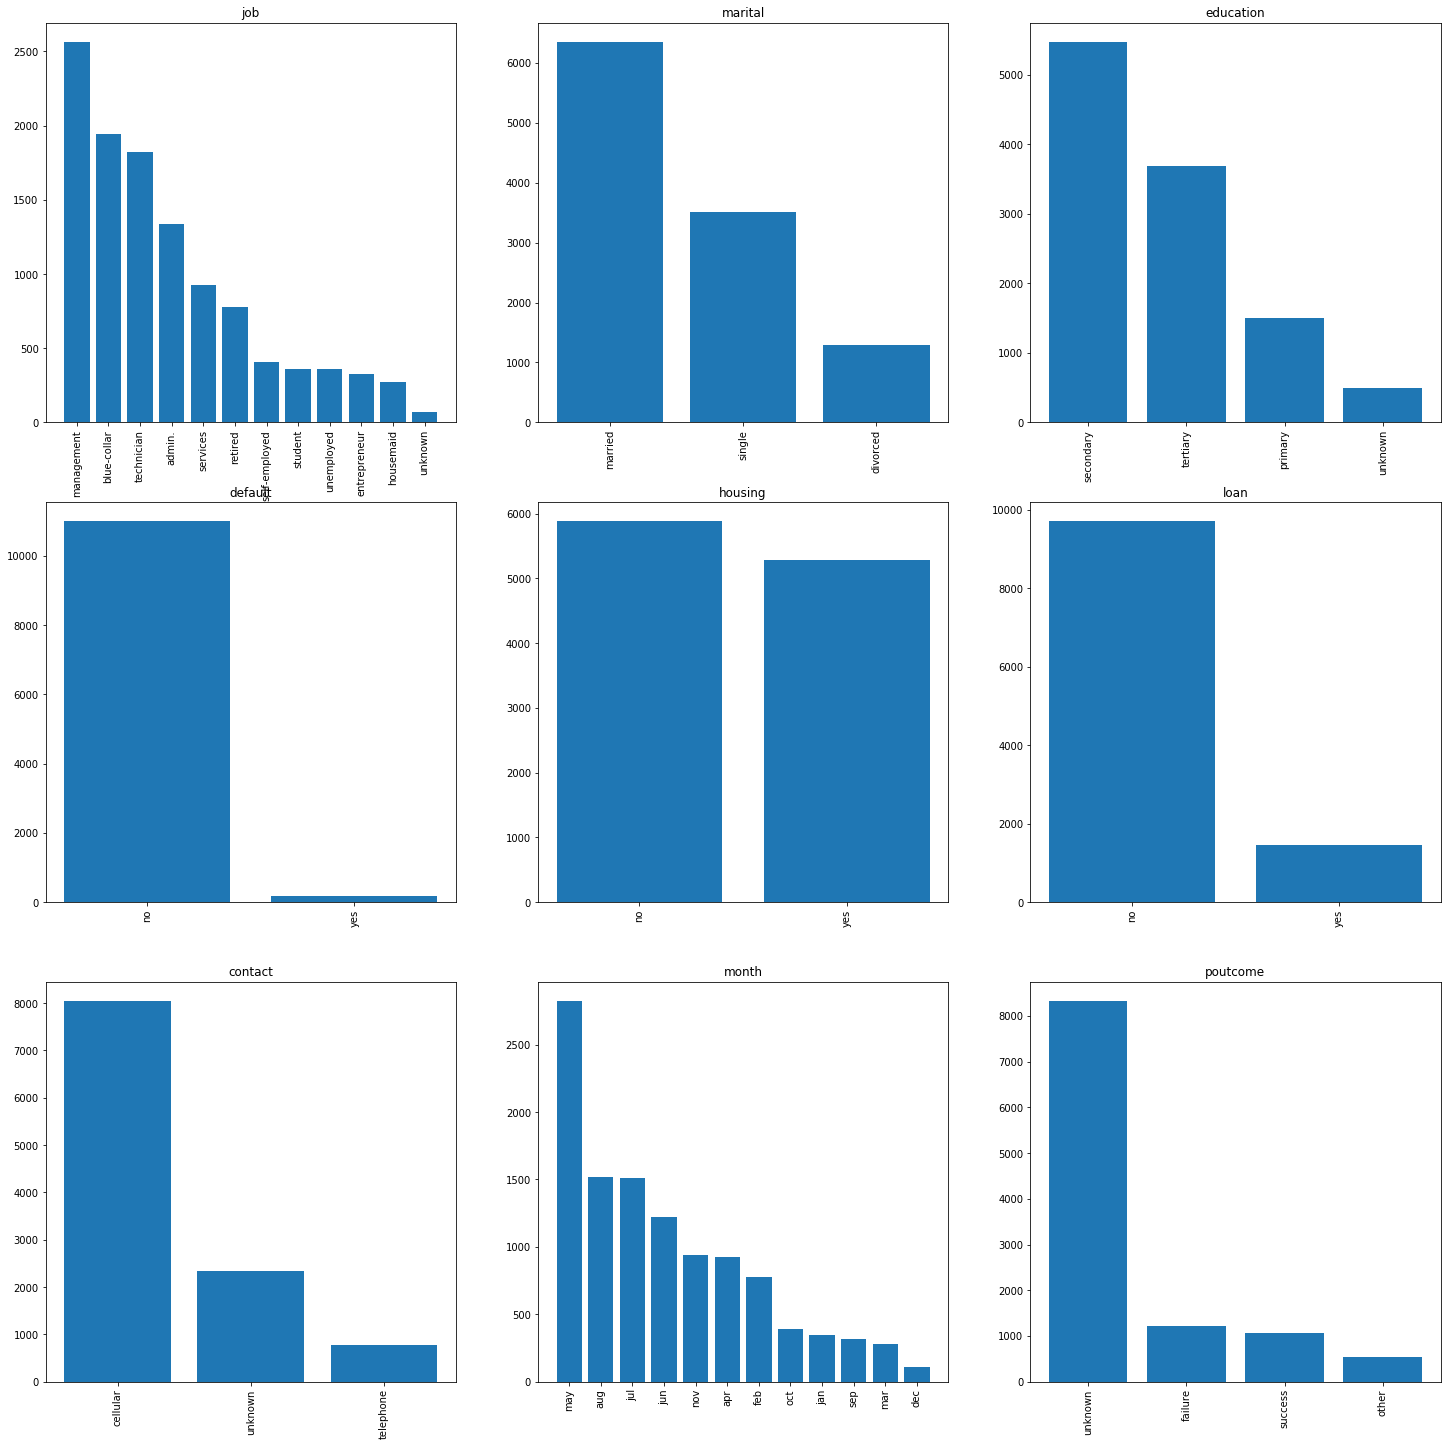

In [5]:
#Exploración de columnas categoricas en el dataset 
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3,3, sharex=False, sharey=False, figsize=(25, 25))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

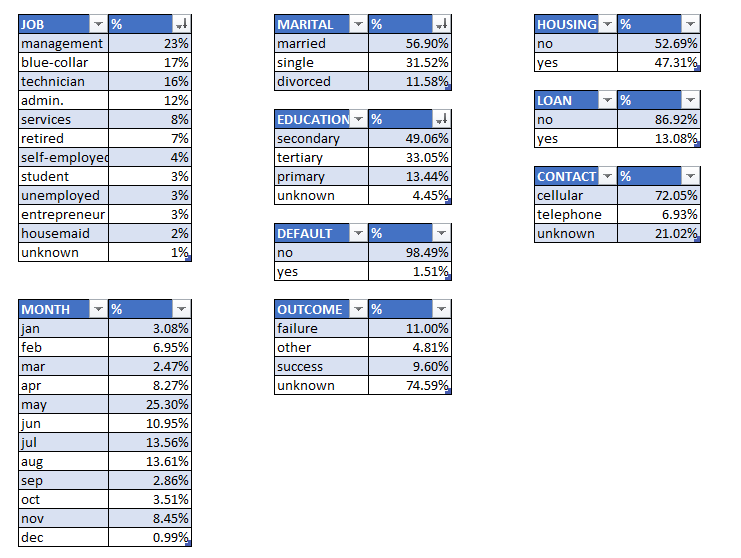

---------------
###### Exploracion de columnas numéricas en el dataset:  

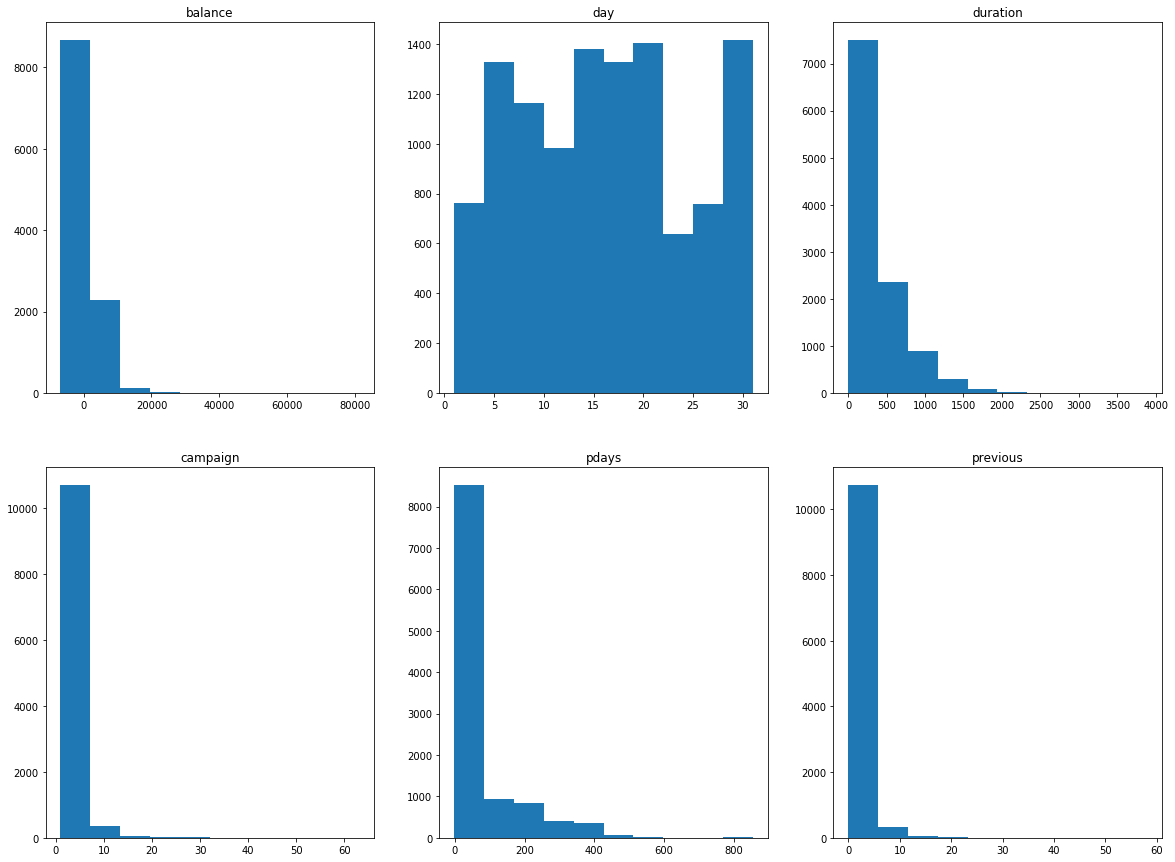

In [6]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

-----------------------

Ahora, procedemos a obtener estadísticas descriptivas para el dataset lo que nos da como resultado: 

In [7]:
len (df[df['pdays'] > 400] ) / len(df) * 100
len (df[df['campaign'] > 34] ) / len(df) * 100
len (df[df['previous'] > 34] ) / len(df) * 100

0.04479483963447411

In [8]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


Sobre las estadísticas descriptivas y aunque nuestra data concluyente se encuentre en las variables categoricas, con respecto a las variables númericas es posible afirmar que: 

1. La edad media es aproximadamente 41 años. Con 18 años y 95 años como mínimo y máximo respectivamente) 
2. El balance medio es 1.528 aunque también debe notarse lo elevado que es el número correspondiente a la desviación estandar. 



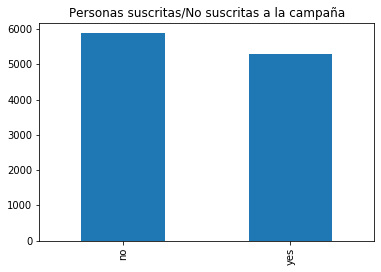

In [9]:
value_counts = df['deposit'].value_counts()
value_counts.plot.bar(title = 'Personas suscritas/No suscritas a la campaña')

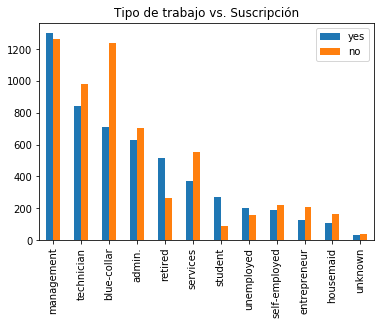

In [10]:

j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Tipo de trabajo vs. Suscripción')

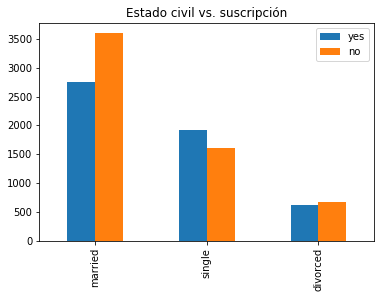

In [11]:
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Estado civil vs. suscripción')

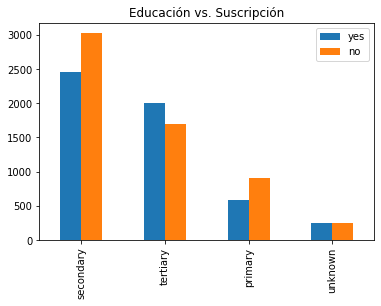

In [12]:
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Educación vs. Suscripción')

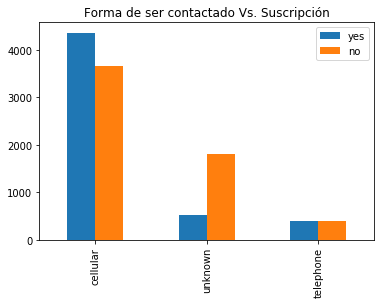

In [13]:
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Forma de ser contactado Vs. Suscripción')

##### Ahora bien, observemos como  las columnas numéricas afectan la suscripción al producto de la campaña: 
1. efecto del balance en la cuenta 
2. efecto de la edad
3. efecto del numero de veces contactado
4. efecto de campañas de marketing pasadas

In [14]:
b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,5873.000000
mean,1804.267915,1280.227141
std,3501.104777,2933.411934
min,-3058.000000,-6847.000000
25%,210.000000,64.000000
50%,733.000000,414.000000
75%,2159.000000,1324.000000
max,81204.000000,66653.000000


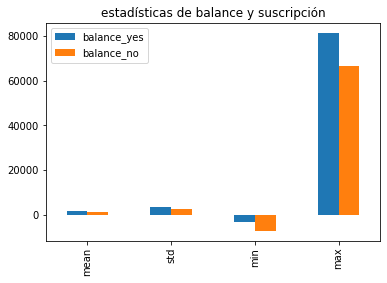

In [15]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'estadísticas de balance y suscripción')

In [16]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,5873.000000
mean,41.670070,40.837391
std,13.497781,10.264815
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


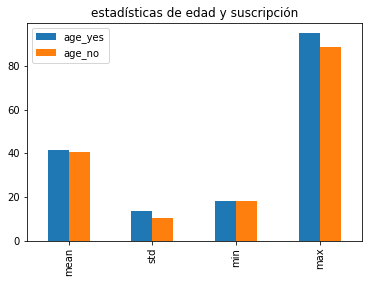

In [17]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'estadísticas de edad y suscripción')

In [18]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,5873.000000
mean,2.141047,2.839264
std,1.921826,3.244474
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


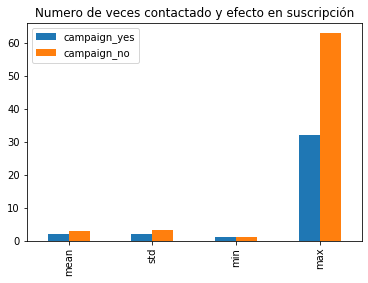

In [19]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Numero de veces contactado y efecto en suscripción')

In [20]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,5873.00000
mean,1.170354,0.52835
std,2.553272,1.97961
min,0.000000,0.00000
25%,0.000000,0.00000
50%,0.000000,0.00000
75%,1.000000,0.00000
max,58.000000,41.00000


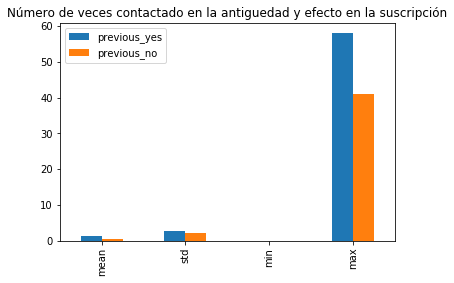

In [21]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Número de veces contactado en la antiguedad y efecto en la suscripción')

##### Con las gráficas que obtuvimos de cruzar nuestra variable objetivo con variables categoricas nos es posible concluir que:

1. Management es el tipo de trabajo que más tienen los clientes de la campaña (23%) 
2. Management/retired son los que tienen el mayor capital en su cuenta bancaria. 
3. Los clientes cuyo tipo de trabajo es 'blue-collar' y 'services' son menos propensos a suscribirse al producto.
4. Los clientes casados son menos propensos a suscribirse al producto.
5. Los clientes con celular como método de contacto son más propensos a suscribirse. 
6. Los clientes que deciden suscribirse al producto, tienden a tener mayor edad y mayor capital en su cuenta bancaria


Ahora bien, hecho el anterior análisis descriptivo y exploratorio es hora de limpiar la data y prepararla para nuestro algoritmo de predicción. 

##### LIMPIAR Y PREPARAR DATA: 

Antes de poder aplicar técnicas de machine learning. Debemos preparar el dataset para ser procesado esto implica:
1. Convertir Yes/No values en columnas booleanas
2. Convertir las columnas categoricas en variables dummy

Por lo anterior, vamos a crear las funciones que nos ayuden en este proceso: 

In [22]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous','contact_unknown','poutcome_success','poutcome_unknown'])
    
    return cleaned_df

In [23]:
#Con los métodos anteriores, transformar el dataset en un dataset limpio
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,campaign_cleaned,previous_cleaned
0,59,2343,5,1042,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
1,56,45,5,1467,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2,41,1270,5,1389,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
3,55,2476,5,579,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1.0,0.0
4,54,184,5,673,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,2.0,0.0


Ahora bien, teniendo nuestro dataset en condiciones ideales. El siguiente paso es usar un algoritmo de Machine Learning para predecir el resultado de la campaña.
Para este paso usare XGBoost, que es una de las librerías de machine learning más comunes para modelar. EL modelo resultante nos dará también luces para entender que variables tienen mayor importancia al momento de predecir los resultados de las campañas. 
Crearé X y Y datasets para entrenar el modelo y las dividiré entre dataset para entrenar y dataset para testear el modelo. 


In [24]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [25]:
TEST_SIZE = 0.25
RAND_STATE = 42

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)


In [27]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#Calcular e imprimir los scores del modelo de las top 15 variables
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.906: test: 0.840


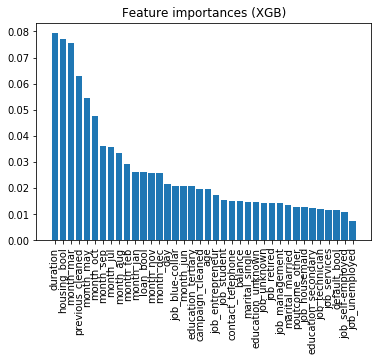

In [28]:
#obtener la importancia de las variables resultado del modelo
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)


x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

#### Resultados: 

Cómo podemos ver en el diagrama superior, las variables más importantes son:
1. Contact duration
2. Housing leasing
3. Estacionalidad, ya que las variables correspondientes a los meses están presentes. (mar-May --> Primavera), (oct, sep,aug --> Otoño) 
4. Número de veces que ha sido contactado
5. edad y balance

---

Por lo anterior, los principales outcomes del modelo son:
1. El número de veces en que un usuario ha sido contactado y la duración del mismo puede ser determinante para hacerlo aceptar o rechazar la oferta.
2. Existe estacionalidad, las personas son mas propensas a aceptar la oferta en Q1 y en Q3 por lo que supongo que en Q2 y Q4 se endeudan. 
3. Housing leasing es una variable que para este caso puede determinar si una persona es más propensa a aceptar la oferta o no.

No obstante podemos ir poquito más allá, 
para eso vamos a mirar en que rangos de balance de dinero en la cuenta debería moverse nuestro target para optimizar los resultados de la campaña. 

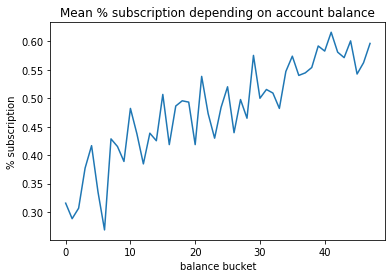

In [29]:
df_new = cleaned_df.copy()

df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')
#Agrupado por buckets de balance y encontrar el average campaign outcome por bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [30]:
df_new[df_new['balance_buckets'] == 30]['balance'].min()

1013

Por la gráfica podemos deducir que el bucket ideal empieza apartir del 30. Ya que el % de suscripción a la campaña está entre el 50% , así que este será el límite mínimo de balance account que vamos a permitir en la campaña próxima: 1.013 USD


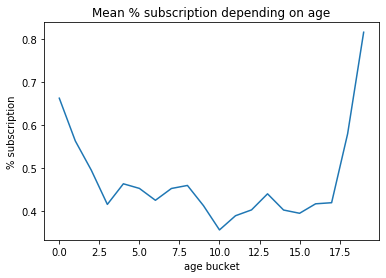

In [31]:

df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#Agrupado por buckets de balance y encontrar el average campaign outcome por bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [32]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [33]:
df_new[df_new['age_buckets'] == 17]['age'].min()

56

Por la gráfica podemos deducir que el bucket ideal empieza apartir del 3. Ya que el % de suscripción a la campaña está cercano al 50% , es por eso que el foco de edad debería ser para clientes menores a 31 años y mayores a 56 años.

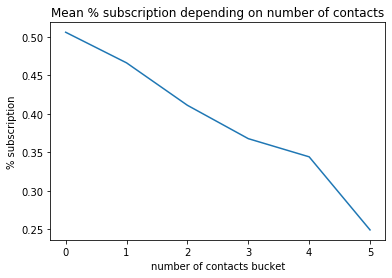

In [34]:

df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')


#Agrupado por buckets de balance y encontrar el average campaign outcome por bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()


plt.plot(mean_campaign.index, mean_campaign.values)
plt.title('Mean % subscription depending on number of contacts')
plt.xlabel('number of contacts bucket')
plt.ylabel('% subscription')
plt.show()

Ya que el % de suscripción a la campaña presenta su mayor drop-off para más de 3 contactos, se establece el límite máximo de contacto a un cliente en 3 ocasiones. Para máximizar tiempos de contacto y de conversión de campañas